# PAINTING WITH GAN

This notebook demonstrates how to build and train a Generative Adversarial Network (GAN) for generating images of oil-painted portraits. GANs are a type of unsupervised learning model that learn to capture patterns in data and generate new samples that resemble the original dataset. The dataset used here consists of portraits with varying orientations and poses, making the task challenging but interesting.

## Table of Contents

1. [Importing Libraries](#1)
2. [Data Loading & Preprocessing](#2)
3. [Building GAN](#3)
    - [The Generator](#3.1)
    - [The Discriminator](#3.2)
4. [GAN Compilation](#4)
5. [Training the Model](#5)
6. [Evaluating the Model](#6)
7. [Conclusion](#7)
8. [End](#8)

---

## 1. Importing Libraries

The following libraries are used in this project:

- **NumPy** and **Pandas** for data manipulation
- **Matplotlib** and **Seaborn** for visualization
- **TensorFlow** and **Keras** for building and training neural networks
- **PIL** for image processing
- **Other utilities** for managing files and warnings

---

In [1]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

## 2. Data Loading & Preprocessing

For this project, we use a dataset of portrait images in JPG format from various artists. Images are loaded as a TensorFlow Dataset with a batch size of 64 and resized to (64, 64) pixels to reduce computational requirements.

**Loading the data:**  
We import the images and prepare them for model training in the next steps.

In [2]:
#Importing data
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


Now that I have the dataset loaded, let us have a look at a few images.

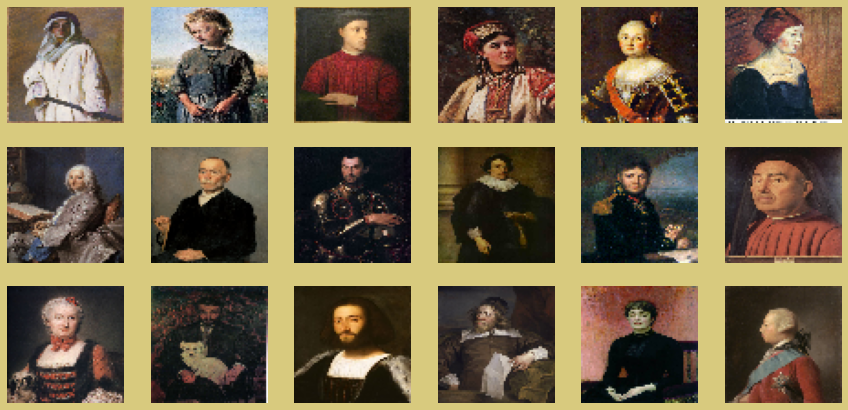

In [3]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

Most of the images are portraits. A portrait is a representation of a person, mainly focusing on the face, expressions, and posture to reflect the subject’s personality.  
Since our GAN model is relatively small, we reduced the image size.  

## Preprocessing the Data

**Normalization:**  
We normalize the image data to the range [0, 1] for faster convergence and efficient computation.  
Each RGB channel has pixel values from 0 to 255. Dividing by 255 scales them to [0, 1], simplifying calculations.


In [4]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<MapDataset shapes: (None, 64, 64, 3), types: tf.float32>

Now that the data is prepared as a TensorFlow Dataset object and preprocessed, the next step is building the GAN.

# Building GAN

Generative Adversarial Networks (GANs) use deep learning methods to frame the task as a supervised learning problem.  
A GAN consists of two models:

- **Generator**: Learns to create images similar to the dataset.  
- **Discriminator**: Learns to distinguish between real images and generated (fake) images.

Both models are trained together in an adversarial setup.  
The generator improves to produce more realistic images, while the discriminator improves at spotting fakes.  
Training reaches equilibrium when the discriminator can no longer reliably tell real from fake images.

---

## The Generator

The Generator is a neural network that creates images from random noise.  
Over time, as training progresses, the generator learns to produce outputs that closely resemble the training data.  
The discriminator then evaluates these outputs, pushing the generator to improve further.

**Steps to build the Generator:**
1. Initialize the model.  
2. Add and define layers.


In [5]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

Now that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process. 

(-0.5, 63.5, 63.5, -0.5)

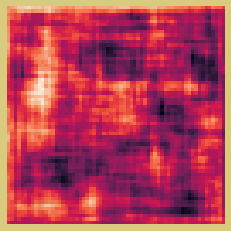

In [6]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Clearly, the initial output is just random noise since the Generator has not been trained yet.  

## The Discriminator

In a GAN, the Generator works together with the Discriminator.  
The Discriminator is a neural network that decides whether the input is real (from the dataset) or fake (produced by the Generator).  

It performs binary classification, using a sigmoid function to output a value between 0 and 1:  
- Close to **1** → Real image  
- Close to **0** → Fake image  

**Steps to build the Discriminator:**
1. Initialize the model.  
2. Add and define layers.  


In [7]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

Now with this discriminator(untrained), let us see what verdict it has for the preiously generated image with random noise. 

In [8]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.50012916]], shape=(1, 1), dtype=float32)


The output of the Discriminator (the verdict) currently shows about a fifty-fifty chance of the image being real.  
This happens because neither the Generator nor the Discriminator is trained yet.  
In short, the untrained Generator produces random noise, and the untrained Discriminator classifies it as "uncertain."  
This is expected and shows we are on the right track.  

## GAN Compilation

Training a GAN involves two main parts:

**Section 1: Training the Discriminator**  
- The Generator is kept idle.  
- The Discriminator is trained on both real images and fake images (produced by the Generator from noise).  
- This helps the Discriminator learn to distinguish real from fake.  

**Section 2: Training the Generator**  
- The Discriminator is kept idle.  
- The Generator is trained using the Discriminator’s predictions.  
- The Generator updates its weights to create outputs that can fool the Discriminator.  

These two steps are repeated for several epochs until both models improve.  

---

## Next Steps  
The following section will define the GAN training process.  


In [9]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Training the Model

Calling the GAN function trains the Generator and Discriminator simultaneously.  

To implement training, we need to define:  
- Number of epochs  
- Optimizers for the Generator and Discriminator  
- Cross-entropy loss function  

After setting these, we can define, compile, and fit the model.  


In [10]:
#Defining the number of epochs
epochs = 200
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/200
65/65 [==============================] - 29s 370ms/step - d_loss: 0.6602 - g_loss: 0.7504
Epoch 2/200
65/65 [==============================] - 22s 306ms/step - d_loss: 0.6798 - g_loss: 0.7718
Epoch 3/200
65/65 [==============================] - 22s 305ms/step - d_loss: 0.6600 - g_loss: 0.8335
Epoch 4/200
65/65 [==============================] - 22s 302ms/step - d_loss: 0.6453 - g_loss: 0.8401
Epoch 5/200
65/65 [==============================] - 22s 300ms/step - d_loss: 0.6602 - g_loss: 0.8622
Epoch 6/200
65/65 [==============================] - 22s 303ms/step - d_loss: 0.6449 - g_loss: 0.8600
Epoch 7/200
65/65 [==============================] - 22s 308ms/step - d_loss: 0.6142 - g_loss: 0.9419
Epoch 8/200
65/65 [==============================] - 22s 307ms/step - d_loss: 0.5981 - g_loss: 0.9897
Epoch 9/200
65/65 [==============================] - 22s 306ms/step - d_loss: 0.5748 - g_loss: 1.0534
Epoch 10/200
65/65 [==============================] - 22s 303ms/step - d_loss: 0.5

## Evaluating the Model

Now that the model is trained, we can evaluate its performance.  
One way to do this is by plotting the learning curves.  

## Plotting the Learning Curves
The learning curves show how the Generator and Discriminator losses change over time, giving us insight into training stability and convergence.


Text(0.5, 1.0, 'Learning Curve')

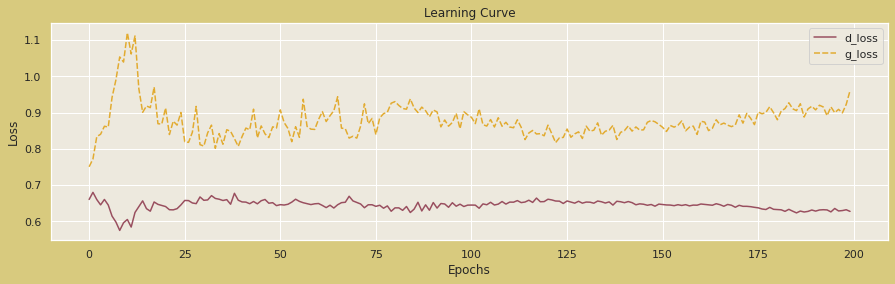

In [12]:
import pandas as pd
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

## AI Makes Artwork

Finally, let’s generate some portraits with our trained GAN and appreciate the artwork it creates.  
We will define a function to save and plot the generated portraits.  


In [13]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


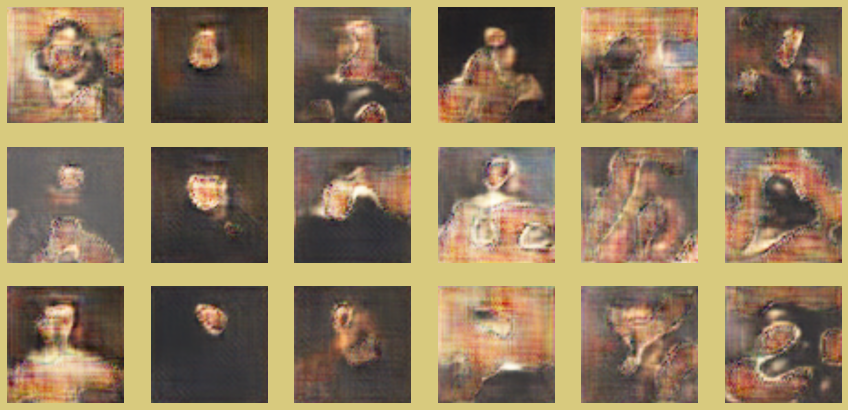

In [14]:
#Loading generated images
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)

## Conclusion

From the evaluation, we can see that the GAN successfully learned patterns in the portraits and performed reasonably well.  
For further improvement:  
- Increase the dataset size, since GANs are data-hungry.  
- Clean the dataset to reduce inconsistencies in portrait styles.  
- Train the model for more epochs.  
- Experiment with more robust neural network architectures.  

**Read More on My Blog:** [AI Art](https://karnikakapoor.blogspot.com/2021/12/ai-art.html)  

**Resources:**  
- [TensorFlow DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)  
- [Keras DCGAN](https://keras.io/examples/generative/dcgan_overriding_train_step/)  
- [Training a GAN](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)  

---

If you liked this Notebook, please **upvote**.  
If you have any questions, feel free to comment!  
✨ Best Wishes ✨  

---

## End
